In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from gym import utils
import gym
import pickle

### MLens Dataset Loading & Preparation

In [3]:
# Loading the MovieLens dataset
ML_LATEST_SMALL_DATA_ROOT_PATH = "../data/dt-datasets/movielens/ml-latest-small"
ML_LATEST_DATA_ROOT_PATH = "../data/dt-datasets/movielens/ml-latest"

##### Load the ML-latest-small dataset

In [4]:
links_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "links.csv"))
movies_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "ratings.csv"))
tags_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "tags.csv"))
print(f"links shape: {links_df.shape}\nmovies shape: {movies_df.shape}\nratings shape: {ratings_df.shape}\ntags shape: {tags_df.shape}")

links shape: (9742, 3)
movies shape: (9742, 3)
ratings shape: (100836, 4)
tags shape: (3683, 4)


min no of rating: 20, max no of rating: 2698
average rating per user: 165.30491803278687, median rating per user: 70.5
number of users who rated less than 140 movies: 429


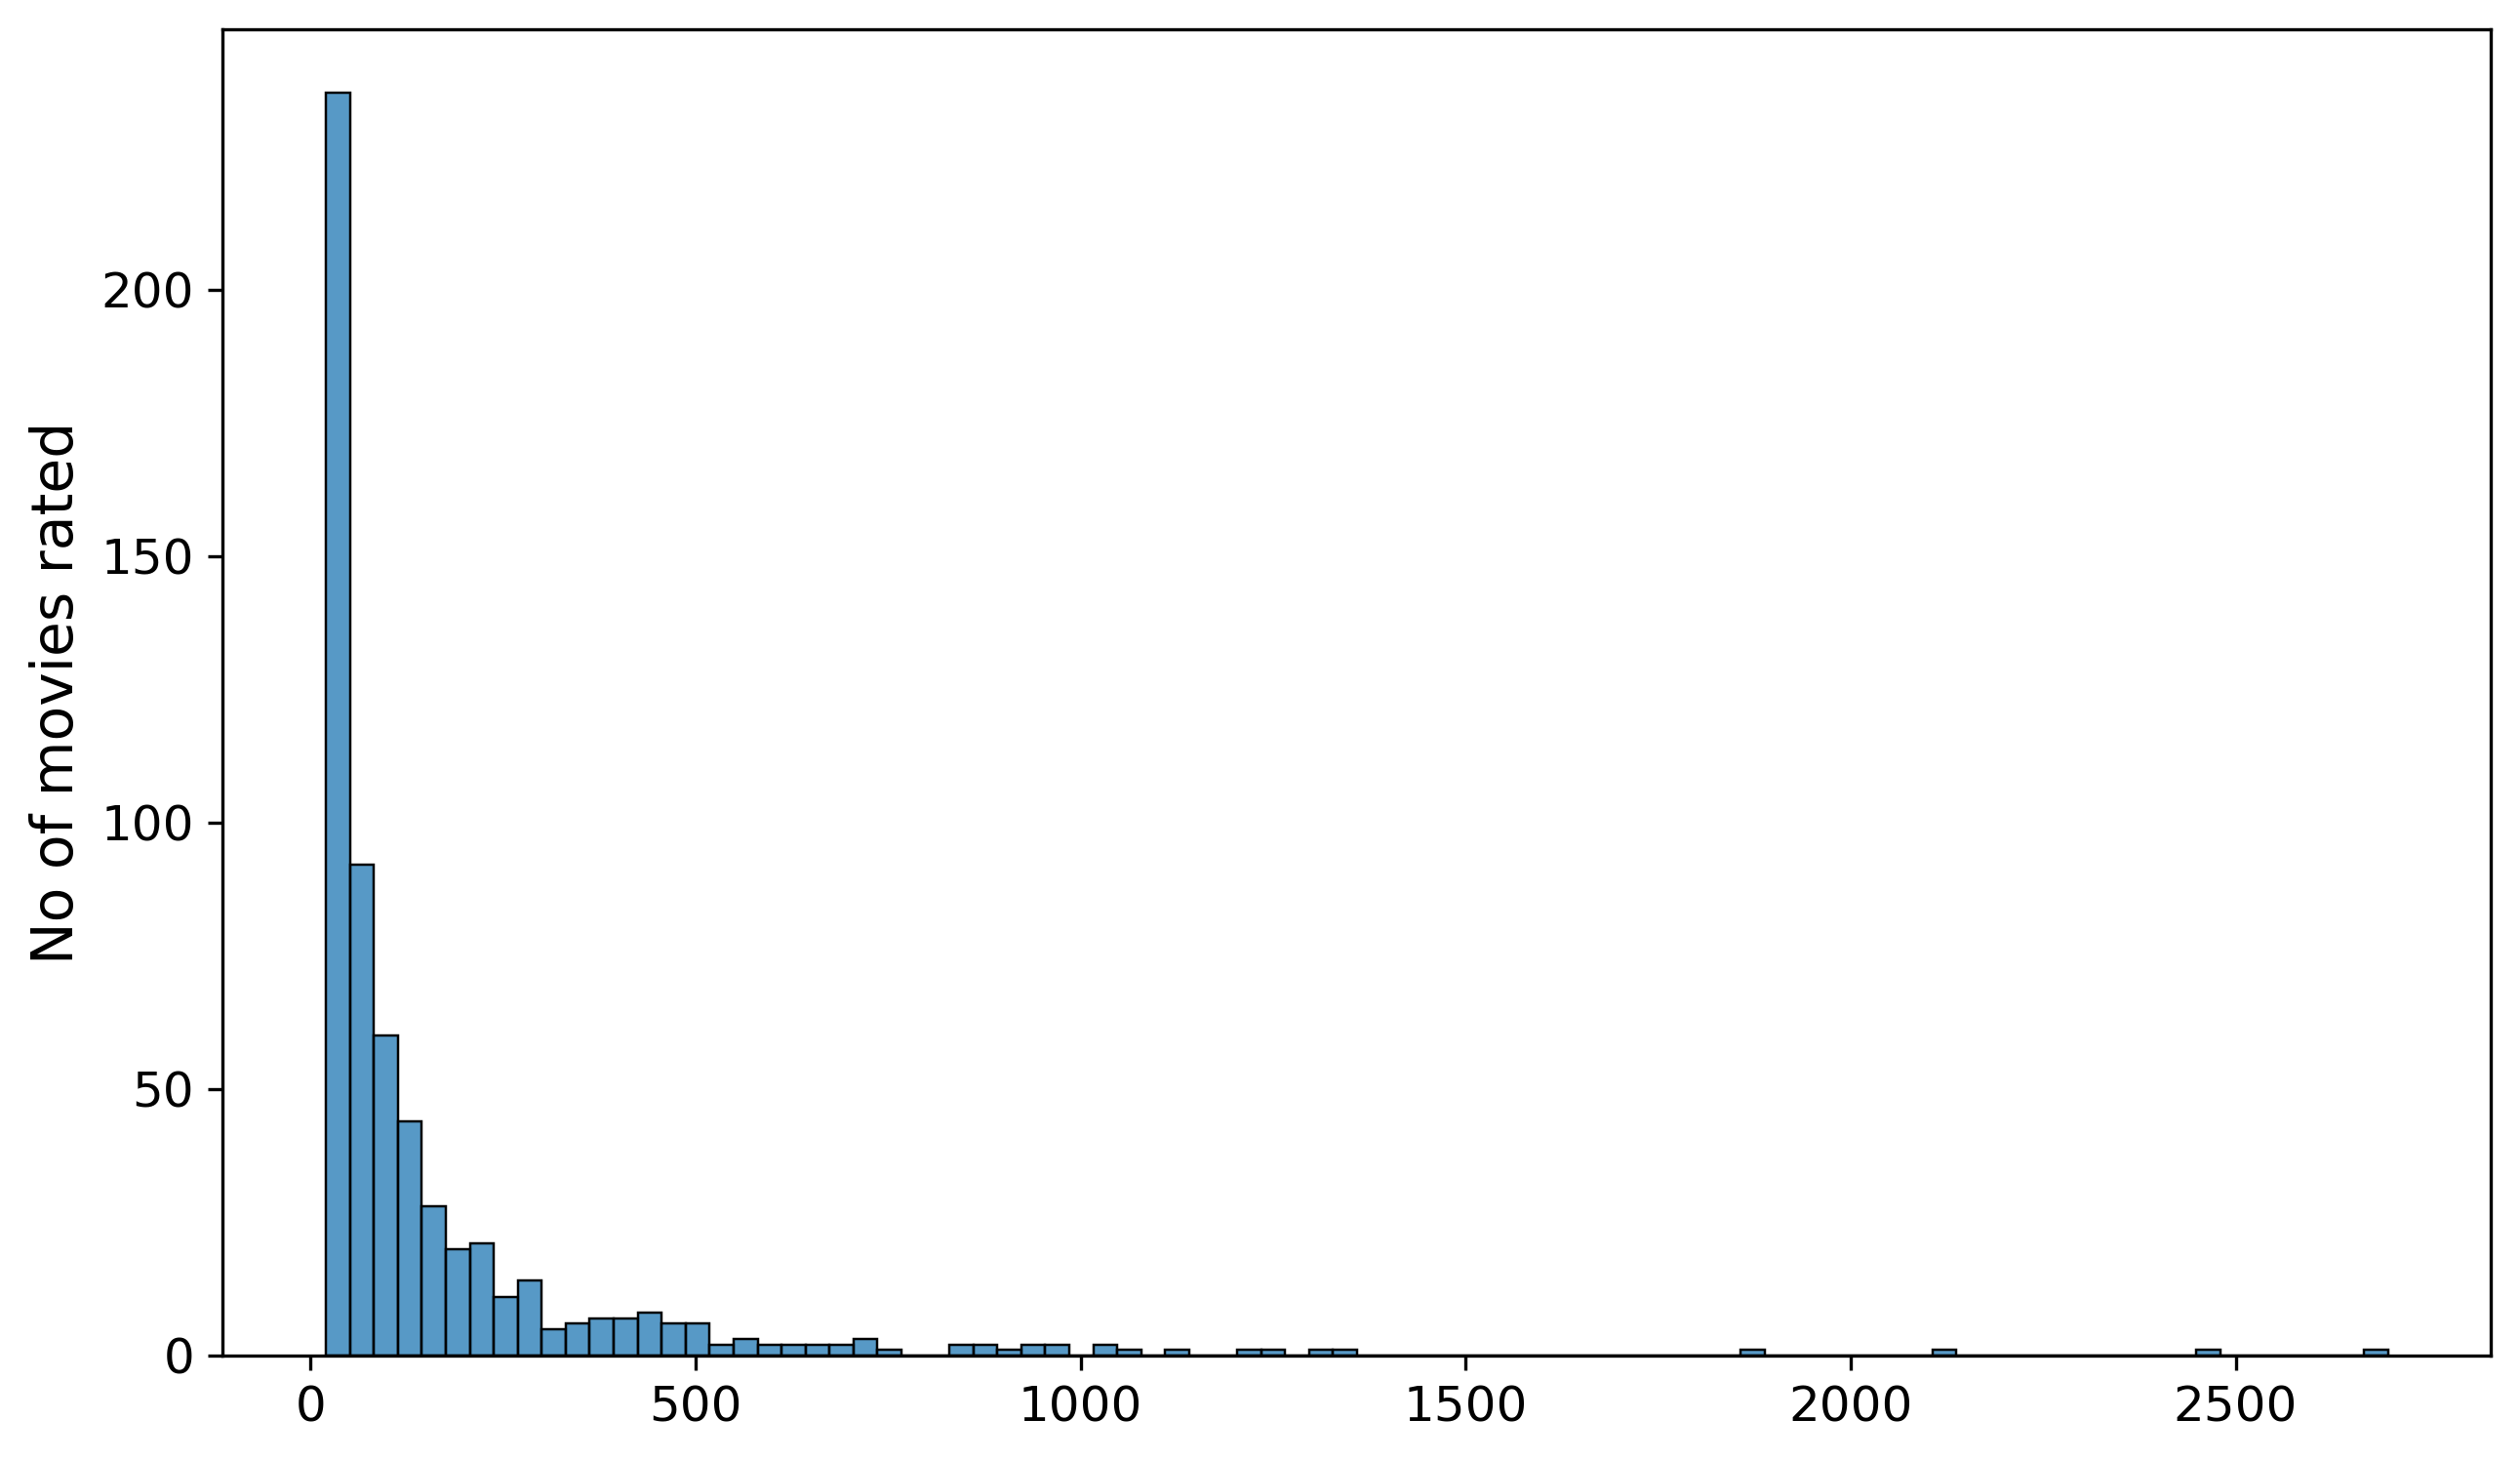

In [22]:
# Data distribution of the rating count per user in the small dataset
rating_count_per_user = ratings_df.groupby('userId')['movieId'].count().values
print(f'min no of rating: {np.min(rating_count_per_user)}, max no of rating: {np.max(rating_count_per_user)}')
print(f'average rating per user: {np.mean(rating_count_per_user)}, median rating per user: {np.median(rating_count_per_user)}')
print(f'number of users who rated less than 140 movies: {(rating_count_per_user <= 140).sum()}')


# Visualize
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})
plt.figure(figsize=(10, 6), dpi=300)
sns.histplot(data = rating_count_per_user)
plt.ylabel("No of movies rated", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.show()
# plt.savefig("../Figures/Movielens/dist_of_no_of_rated_movies_for_users.pdf")
plt.savefig("../Figures/Movielens/dist_of_no_of_rated_movies_for_users.pdf", format="pdf", bbox_inches="tight")
# sns.boxplot(rating_count_per_user)

In [24]:
# List of all the genres
np.unique(np.concatenate(movies_df['genres'].apply(lambda g: g.split("|")).tolist()))

array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

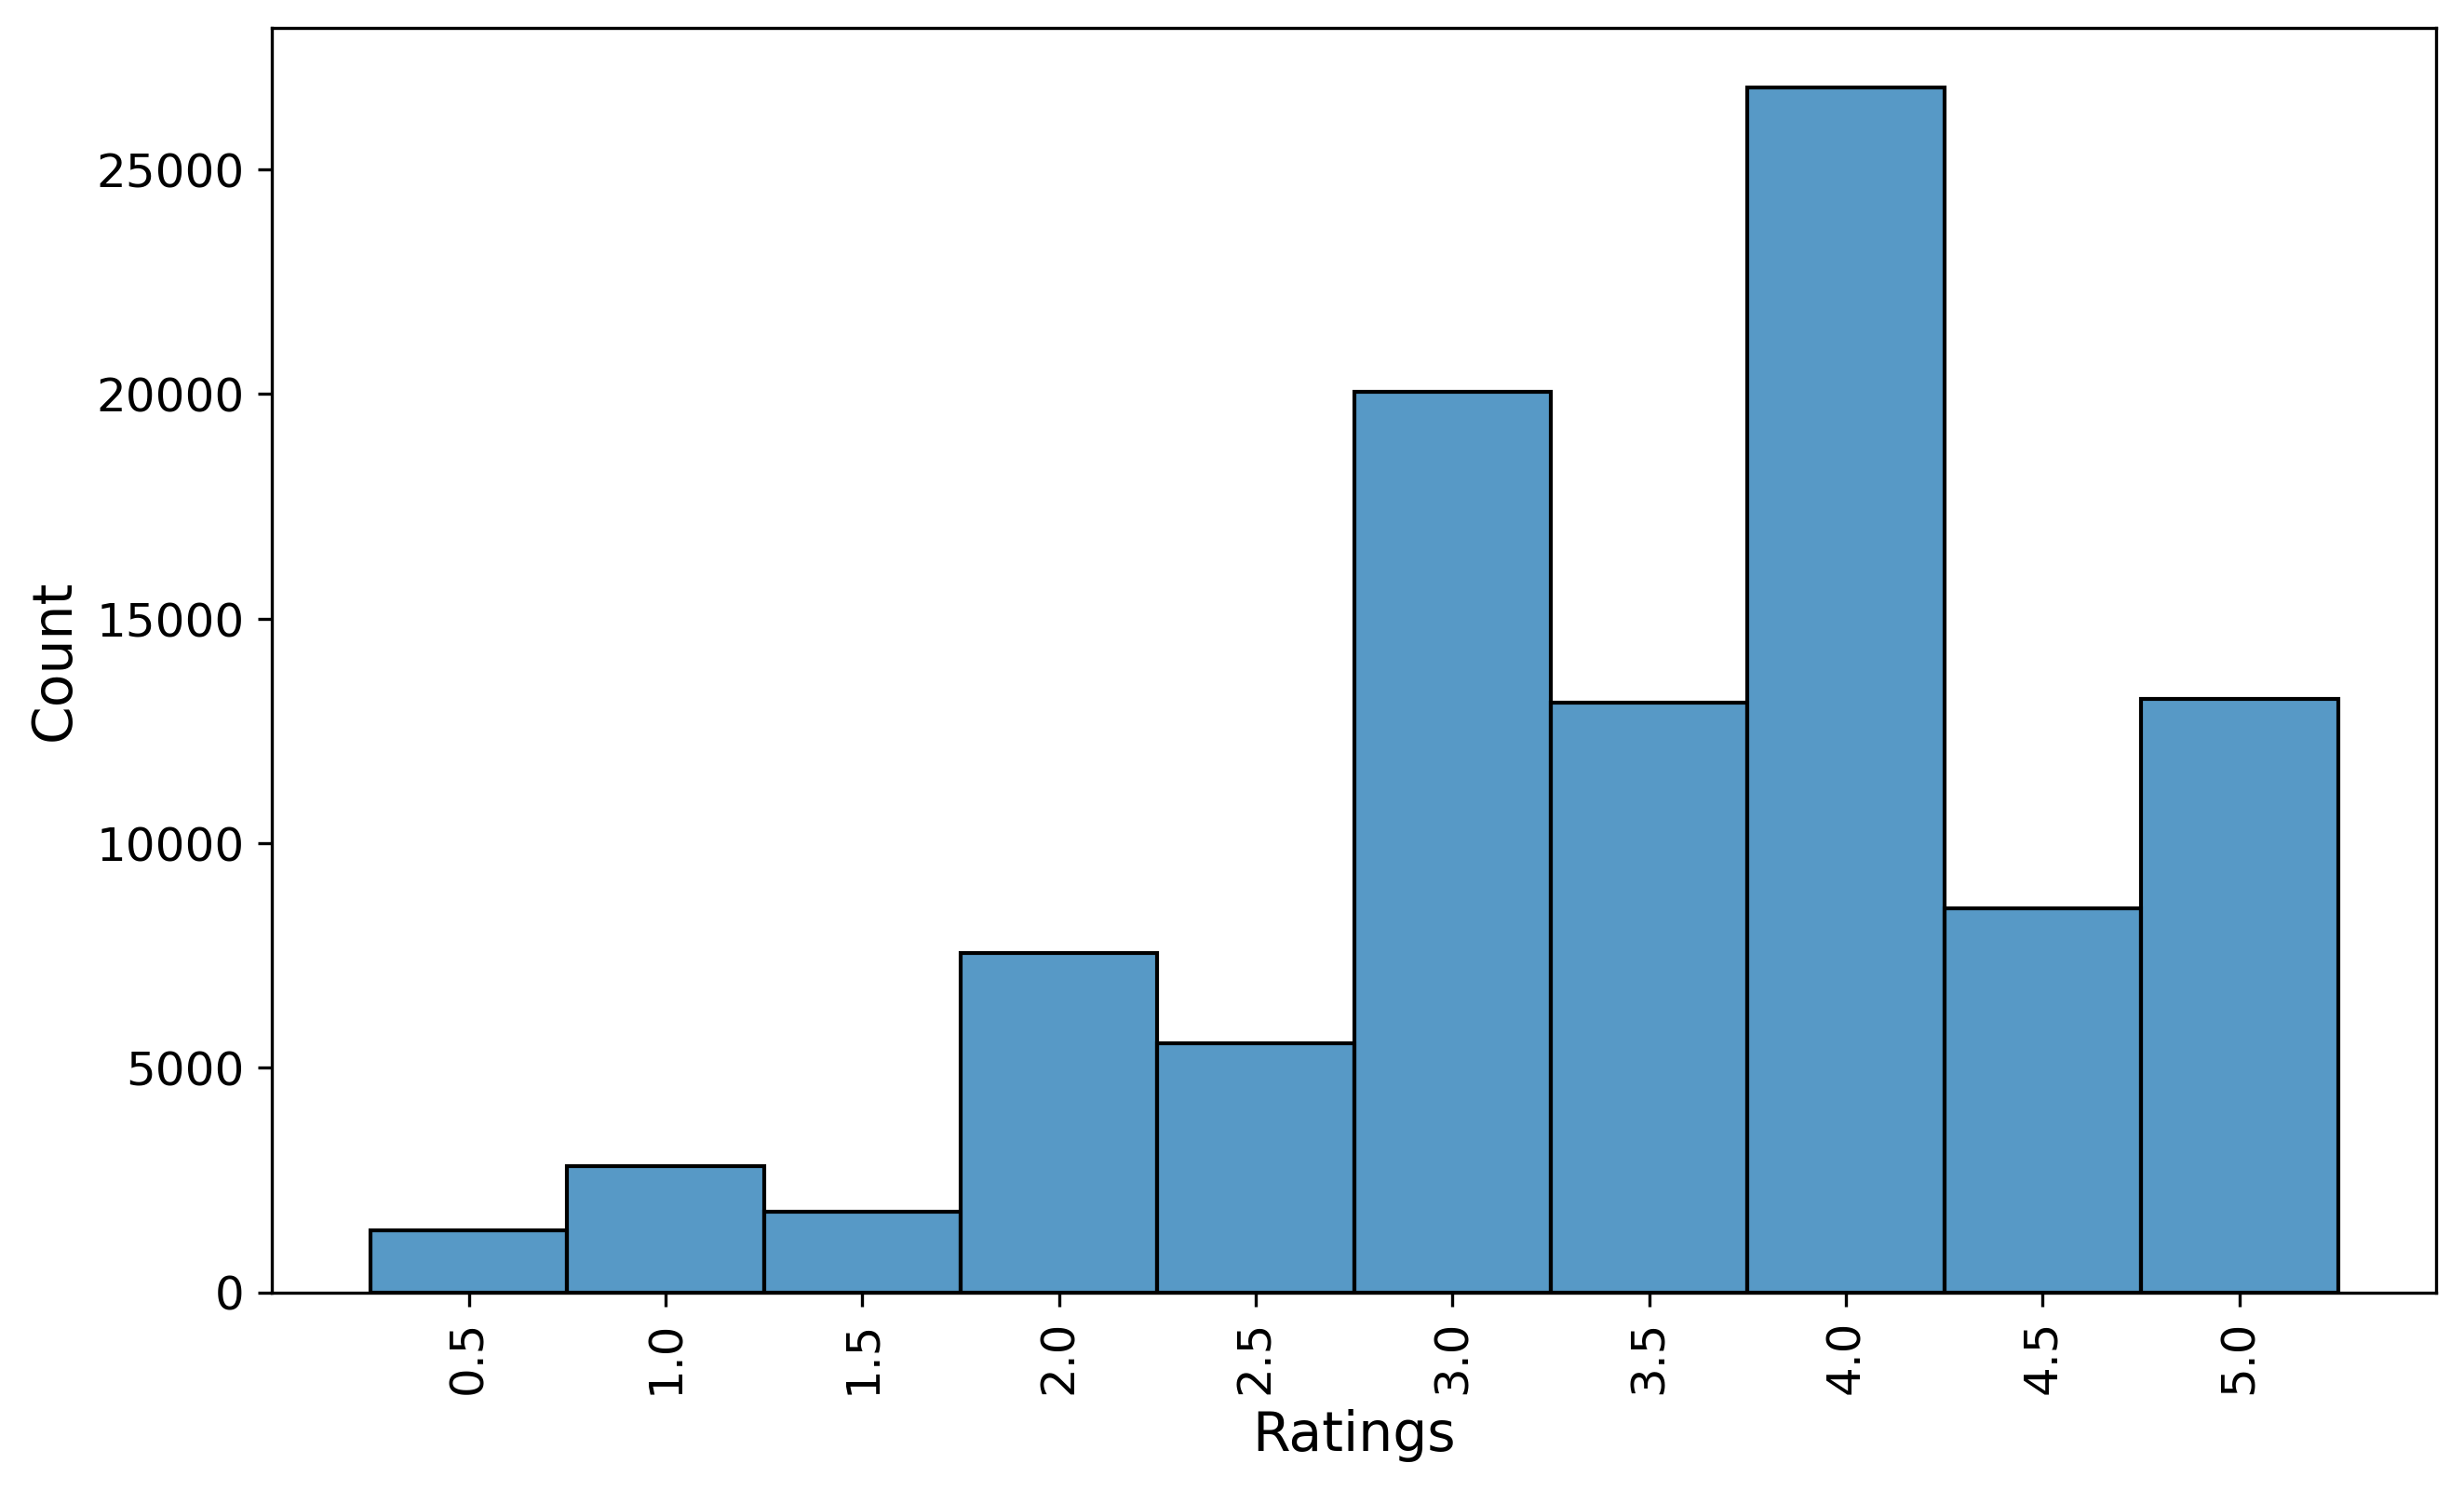

In [34]:
# Distribution of the movie ratings

plt.figure(figsize=(10, 6), dpi=300)
ratings = sorted([str(rating) for rating in ratings_df['rating']])
sns.histplot(ratings)
# plt.xticks(ticks)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Ratings", fontsize = 14)
plt.savefig("../Figures/Movielens/dist_of_movie_ratings.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [40]:
# Movie ratings distribution
min_rating = np.min(ratings_df['rating'])
max_rating = np.max(ratings_df['rating'])
avg_rating = np.mean(ratings_df['rating'])
median_rating = np.median(ratings_df['rating'])
sd = np.std(ratings_df['rating'])
print(f"min: {min_rating}, max: {max_rating}, avg: {avg_rating}, median: {median_rating}, SD: {sd}")

min: 0.5, max: 5.0, avg: 3.501556983616962, median: 3.5, SD: 1.042524069617957


##### Merge the movies and ratings dataframes together

In [41]:
movies_and_ratings = pd.merge(movies_df, ratings_df, on='movieId')
movies_and_ratings.shape

(100836, 6)

In [42]:
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [43]:
# Check if there is any duplicate
print(movies_and_ratings.duplicated().sum())

print(movies_and_ratings.isna().sum())
movies_and_ratings[movies_and_ratings[['movieId', 'userId']].duplicated(keep=False)]

0
movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


,movieId,title,genres,userId,rating,timestamp


In [ ]:
movies_and_ratings.dtypes

In [44]:
# Check if there are any null values
movies_and_ratings['userId'].isna().sum(),  movies_and_ratings['movieId'].isna().sum()

(0, 0)

In [45]:
# Check if all the userIds are present in the merged df as well
sorted(ratings_df.userId.unique()) ==  sorted(movies_and_ratings.userId.unique())

True

In [46]:
# Sort the movie ratings by userId and timestamp in an ascending manner
movies_and_ratings = movies_and_ratings.sort_values(by=['userId', 'timestamp'])
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
19452,804,She's the One (1996),Comedy|Romance,1,4.0,964980499
25865,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,5.0,964980499
38361,2018,Bambi (1942),Animation|Children|Drama,1,5.0,964980523
45807,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1,4.0,964980523
48507,2826,"13th Warrior, The (1999)",Action|Adventure|Fantasy,1,4.0,964980523


In [47]:
# Find out the different rating values
sorted(movies_and_ratings['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [48]:
# Another reward scheme
# Scaling the rewards between 0 & 1
highest_rating = 5.0
movies_and_ratings['reward'] = (1 - abs(movies_and_ratings['rating'] - highest_rating) / 4.5) ** 2

In [49]:
# Number of rated movies per user
grouped = movies_and_ratings.groupby('userId')

In [55]:
no_of_ratings_per_user = movies_and_ratings['userId'].value_counts()

In [58]:
no_of_ratings_per_user.min(), no_of_ratings_per_user.max(), no_of_ratings_per_user.mean(), no_of_ratings_per_user.median()

(20, 2698, 165.30491803278687, 70.5)

In [60]:
# Earliest and latest timestamps
movies_and_ratings['timestamp'].min(), movies_and_ratings['timestamp'].max()

(828124615, 1537799250)

In [61]:
all_genres = movies_and_ratings['genres']

19452                   Comedy|Romance
25865          Action|Adventure|Sci-Fi
38361         Animation|Children|Drama
45807          Action|Adventure|Sci-Fi
48507         Action|Adventure|Fantasy
                     ...              
95494                           Horror
2913     Action|Comedy|Horror|Thriller
9056                   Horror|Thriller
44007                           Horror
58232                           Horror
Name: genres, Length: 100836, dtype: object

In [67]:
genres_list = []
for genres in all_genres:
    genre_splitted = genres.split("|")
    genres_list += genre_splitted
genres_arr = np.array(genres_list)
genres_arr.shape

(274480,)

In [68]:
unique_elements, counts = np.unique(genres_arr, return_counts=True)

In [78]:
data = dict(genre=unique_elements, count=counts)
genre_count_df = pd.DataFrame(data)
genre_count_df

,genre,count
0,(no genres listed),47
1,Action,30635
2,Adventure,24161
3,Animation,6988
4,Children,9208
5,Comedy,39053
6,Crime,16681
7,Documentary,1219
8,Drama,41928
9,Fantasy,11834


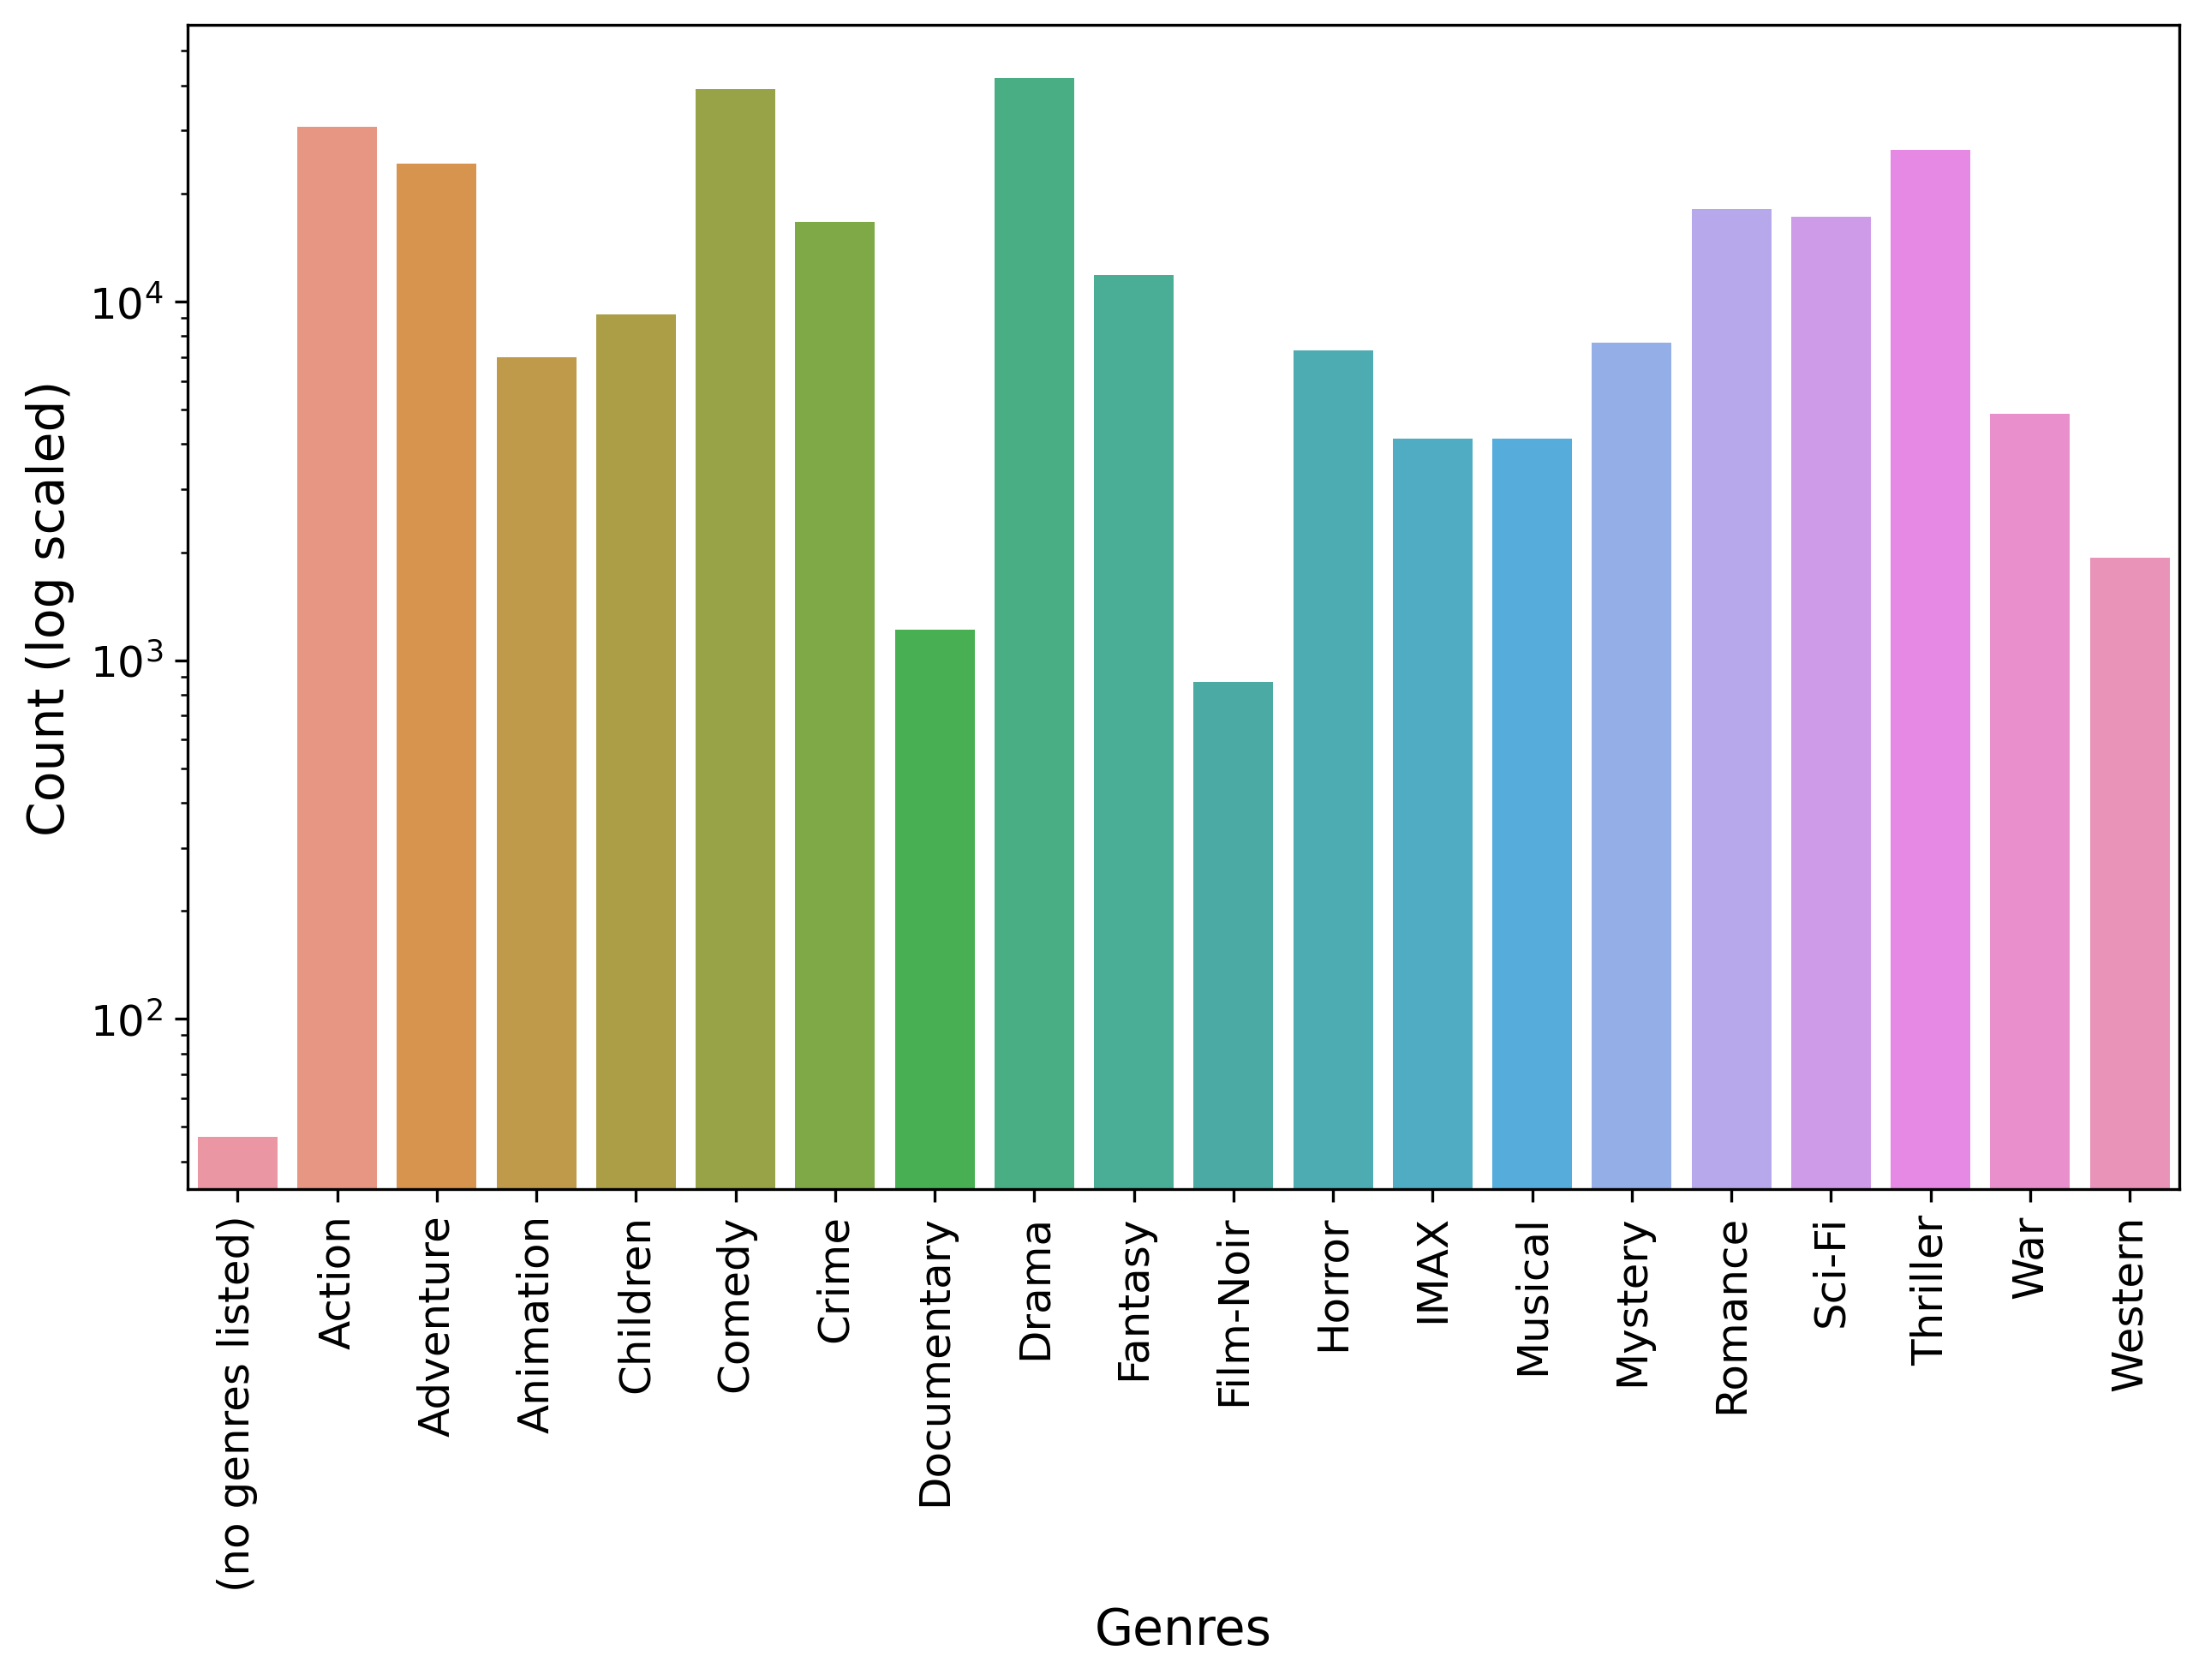

In [96]:
# Create the bar plot with seaborn
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(x="genre", y="count", data=genre_count_df)

plt.xlabel("Genres", fontsize=14)
plt.ylabel("Count (log scaled)", fontsize=14)
plt.yscale("log")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../Figures/Movielens/dist_of_movie_genres.pdf", format="pdf", bbox_inches="tight")

In [99]:
movies_and_ratings[movies_and_ratings['movieId'] == 804]

,movieId,title,genres,userId,rating,timestamp,reward
19452,804,She's the One (1996),Comedy|Romance,1,4.0,964980499,0.604938
19453,804,She's the One (1996),Comedy|Romance,51,5.0,1230931511,1.000000
19454,804,She's the One (1996),Comedy|Romance,113,3.0,980051922,0.308642
19455,804,She's the One (1996),Comedy|Romance,117,3.0,844163929,0.308642
19456,804,She's the One (1996),Comedy|Romance,414,3.0,961439308,0.308642
19457,804,She's the One (1996),Comedy|Romance,489,2.0,1333831977,0.111111
19458,804,She's the One (1996),Comedy|Romance,555,4.0,978744726,0.604938
19459,804,She's the One (1996),Comedy|Romance,603,2.0,963178746,0.111111


In [107]:
movies_and_ratings['genre_count_per_movie'] = movies_and_ratings['genres'].apply(lambda x: len(x.split('|')))

In [111]:
movies_and_ratings['genre_count_per_movie'].max()

10

In [117]:
grouped_tags = tags_df.groupby(['userId', 'movieId'])

In [130]:
tag_counts_per_user = tags_df[['userId', 'movieId']].value_counts().tolist()

In [140]:
np.mean(tag_counts_per_user)

2.074929577464789

In [146]:
tags_df['tag'].value_counts()

In Netflix queue     131
atmospheric           36
superhero             24
thought-provoking     24
Disney                23
                    ... 
aviation               1
nightmare              1
Day and Hudson         1
bad writing            1
revolutionary          1
Name: tag, Length: 1589, dtype: int64

In [138]:
tags_df['tag'].apply(lambda x: x.lower()).nunique()

1475

<AxesSubplot:>

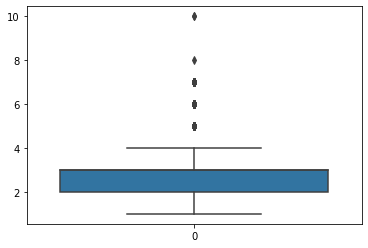

In [150]:
# Outlier analysis

sns.boxplot(data = movies_and_ratings['genre_count_per_movie'])
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Count (log scaled)", fontsize=14)
plt.yscale("log")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

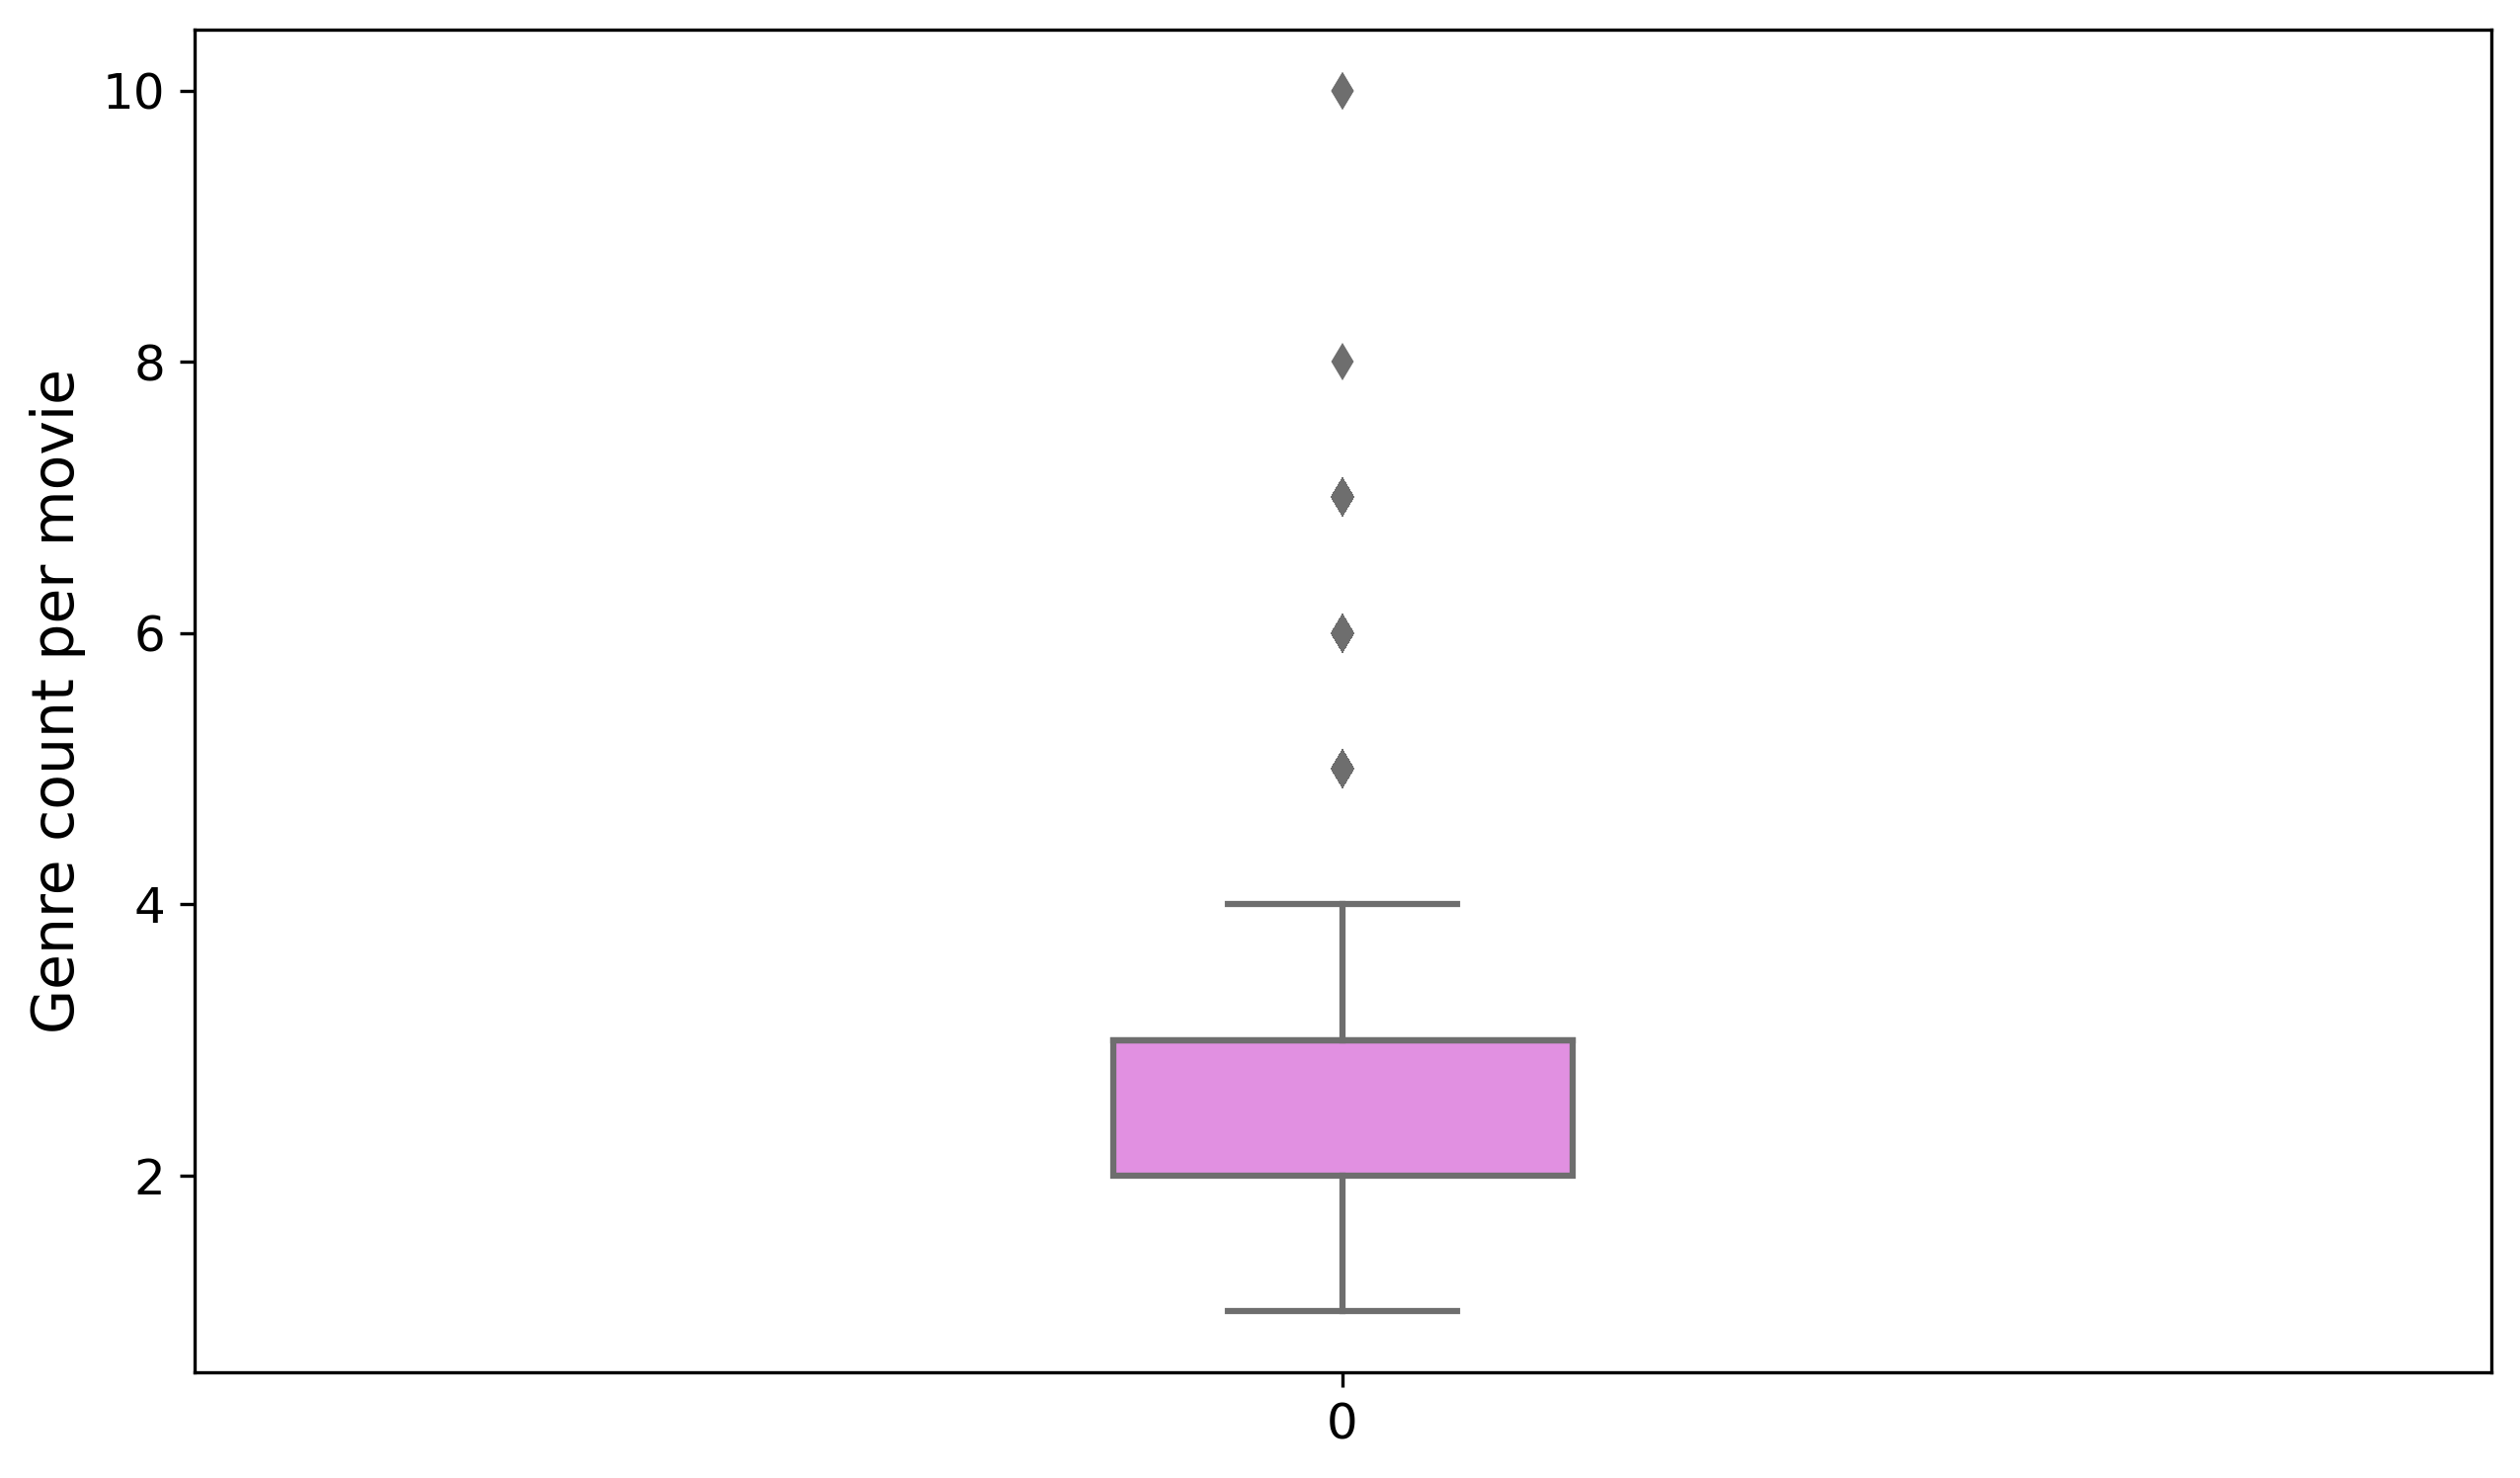

In [183]:
plt.figure(figsize=(10,6), dpi=300)
sns.boxplot(data = movies_and_ratings['genre_count_per_movie'], width=0.2, color='violet')
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Genre count per movie", fontsize=14)
# plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../Figures/Movielens/boxplot_genre_count_per_movie.pdf", format="pdf", bbox_inches="tight")

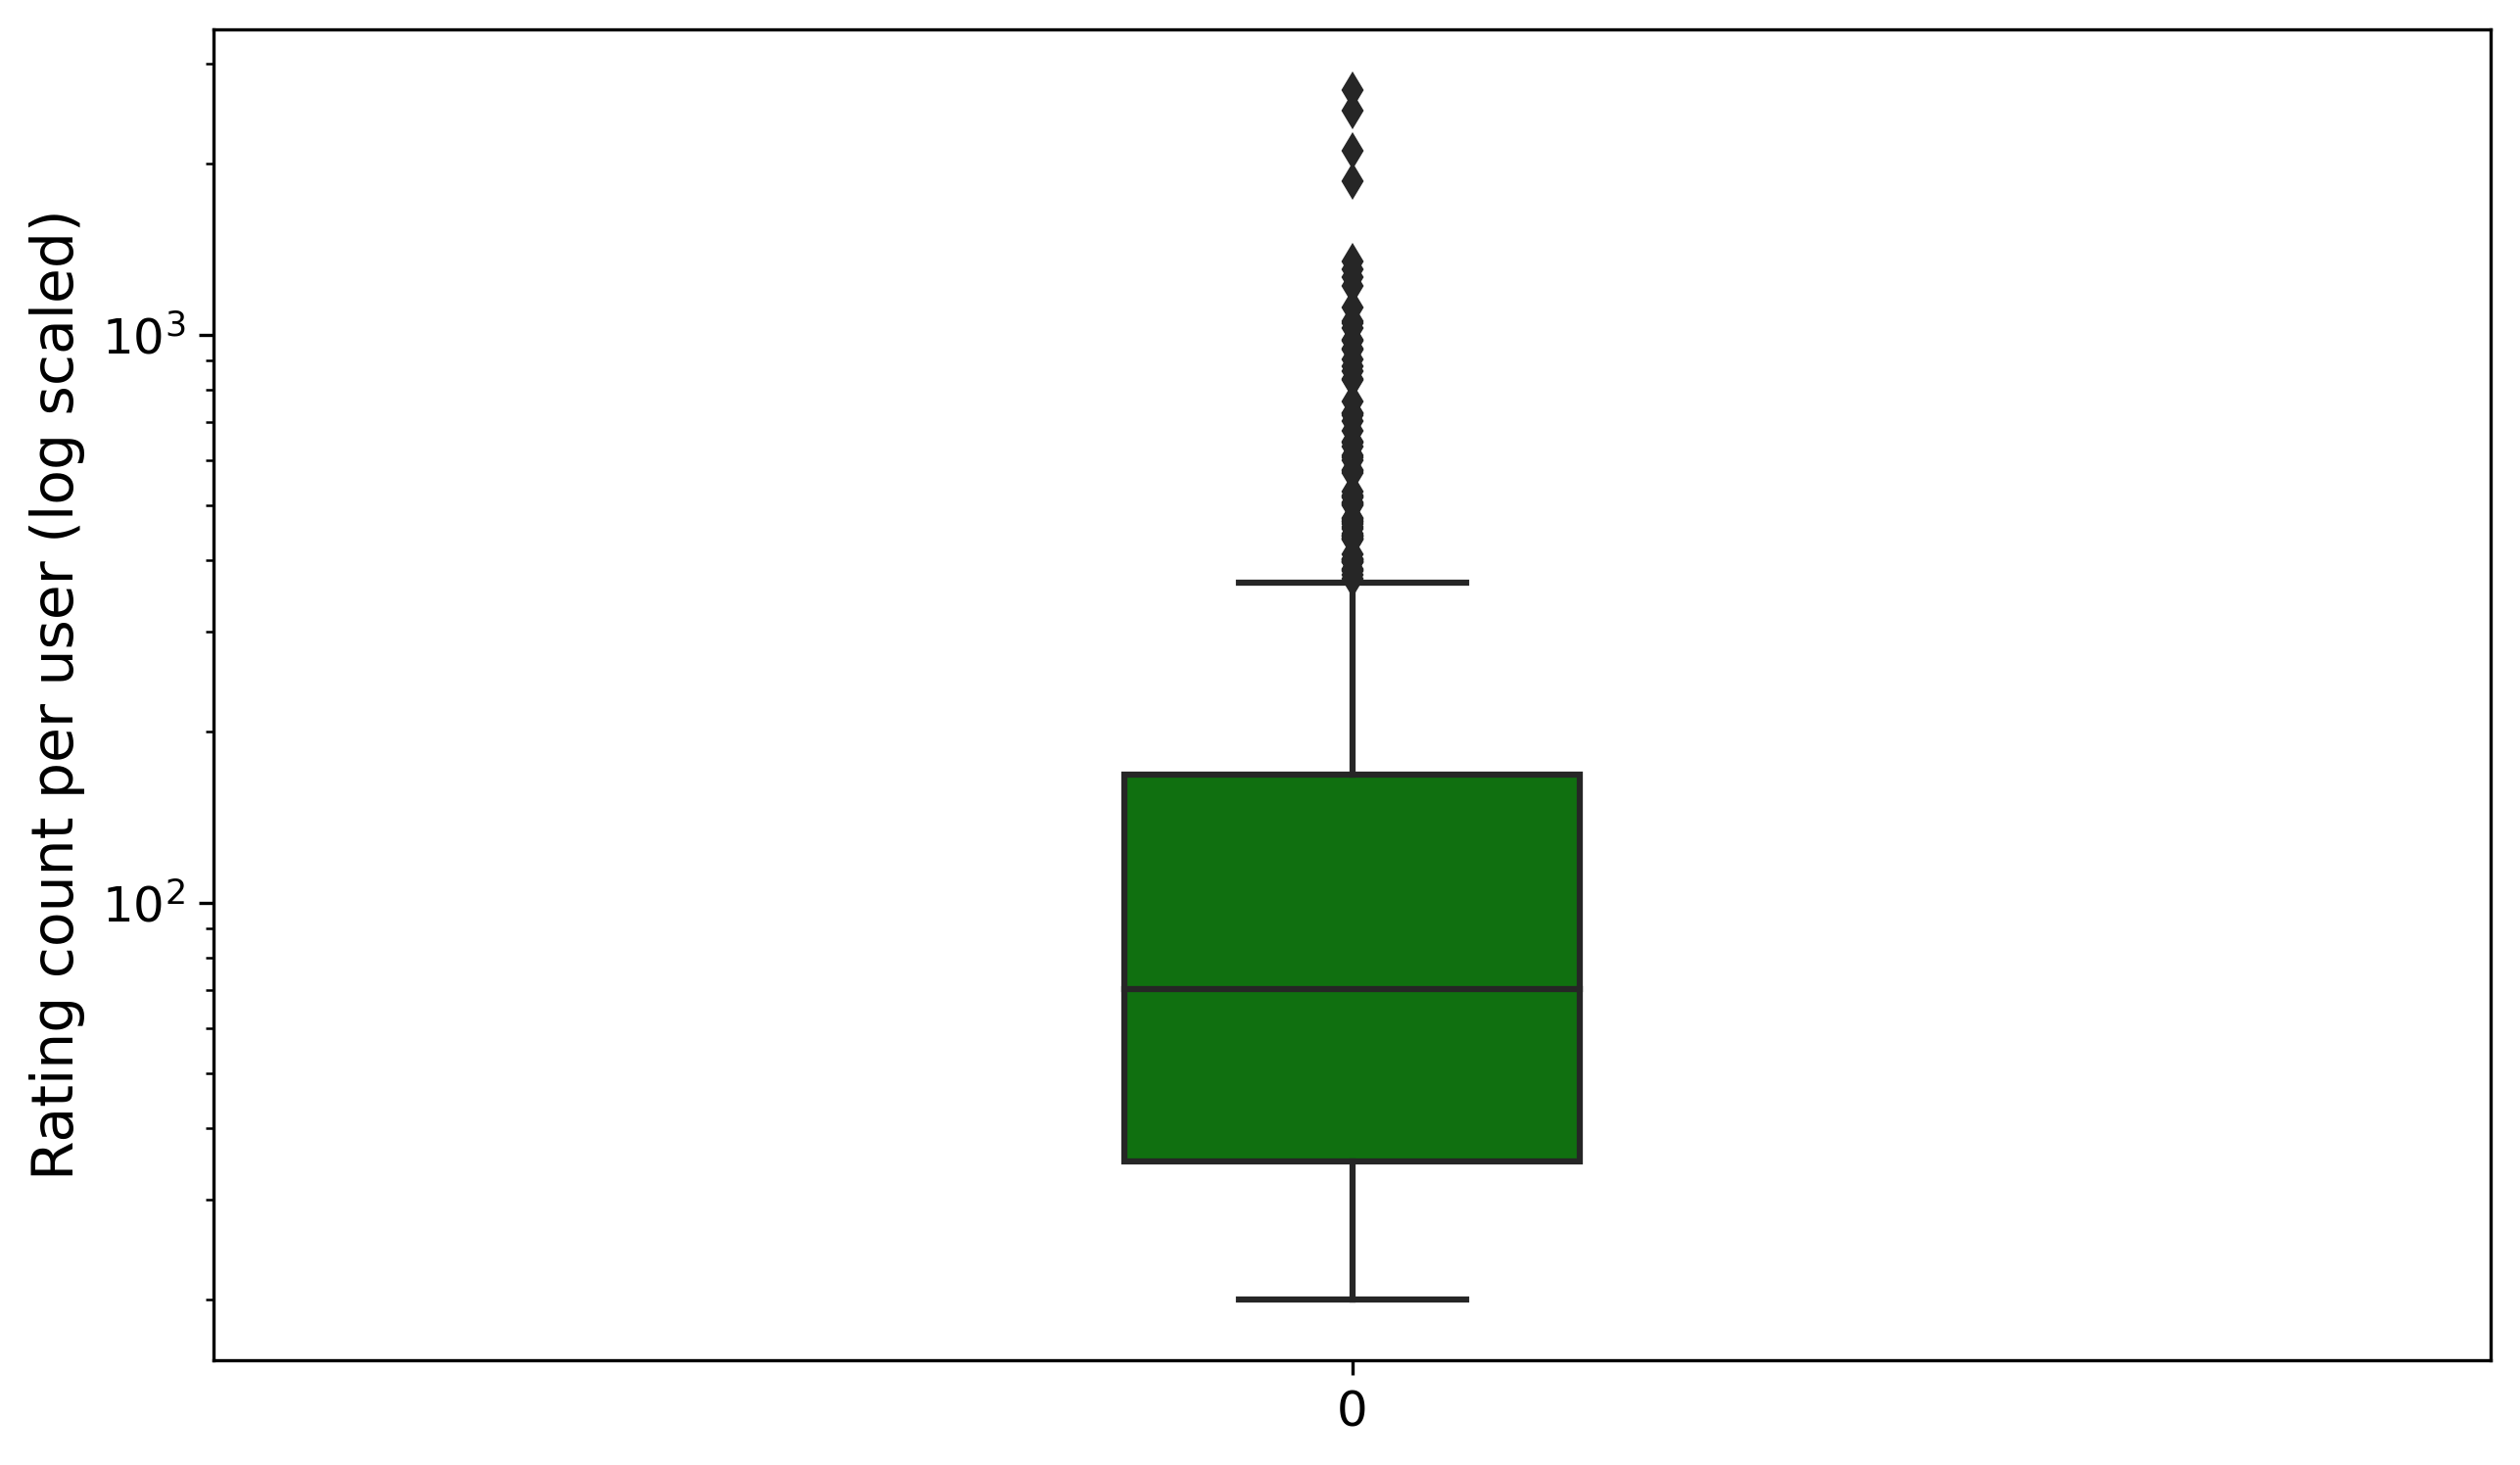

In [182]:
plt.figure(figsize=(10,6), dpi=300)
sns.boxplot(data = ratings_df['userId'].value_counts().tolist(), width=0.2, color='green')
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Rating count per user (log scaled)", fontsize=14)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../Figures/Movielens/boxplot_per_user_rating_count.pdf", format="pdf", bbox_inches="tight")

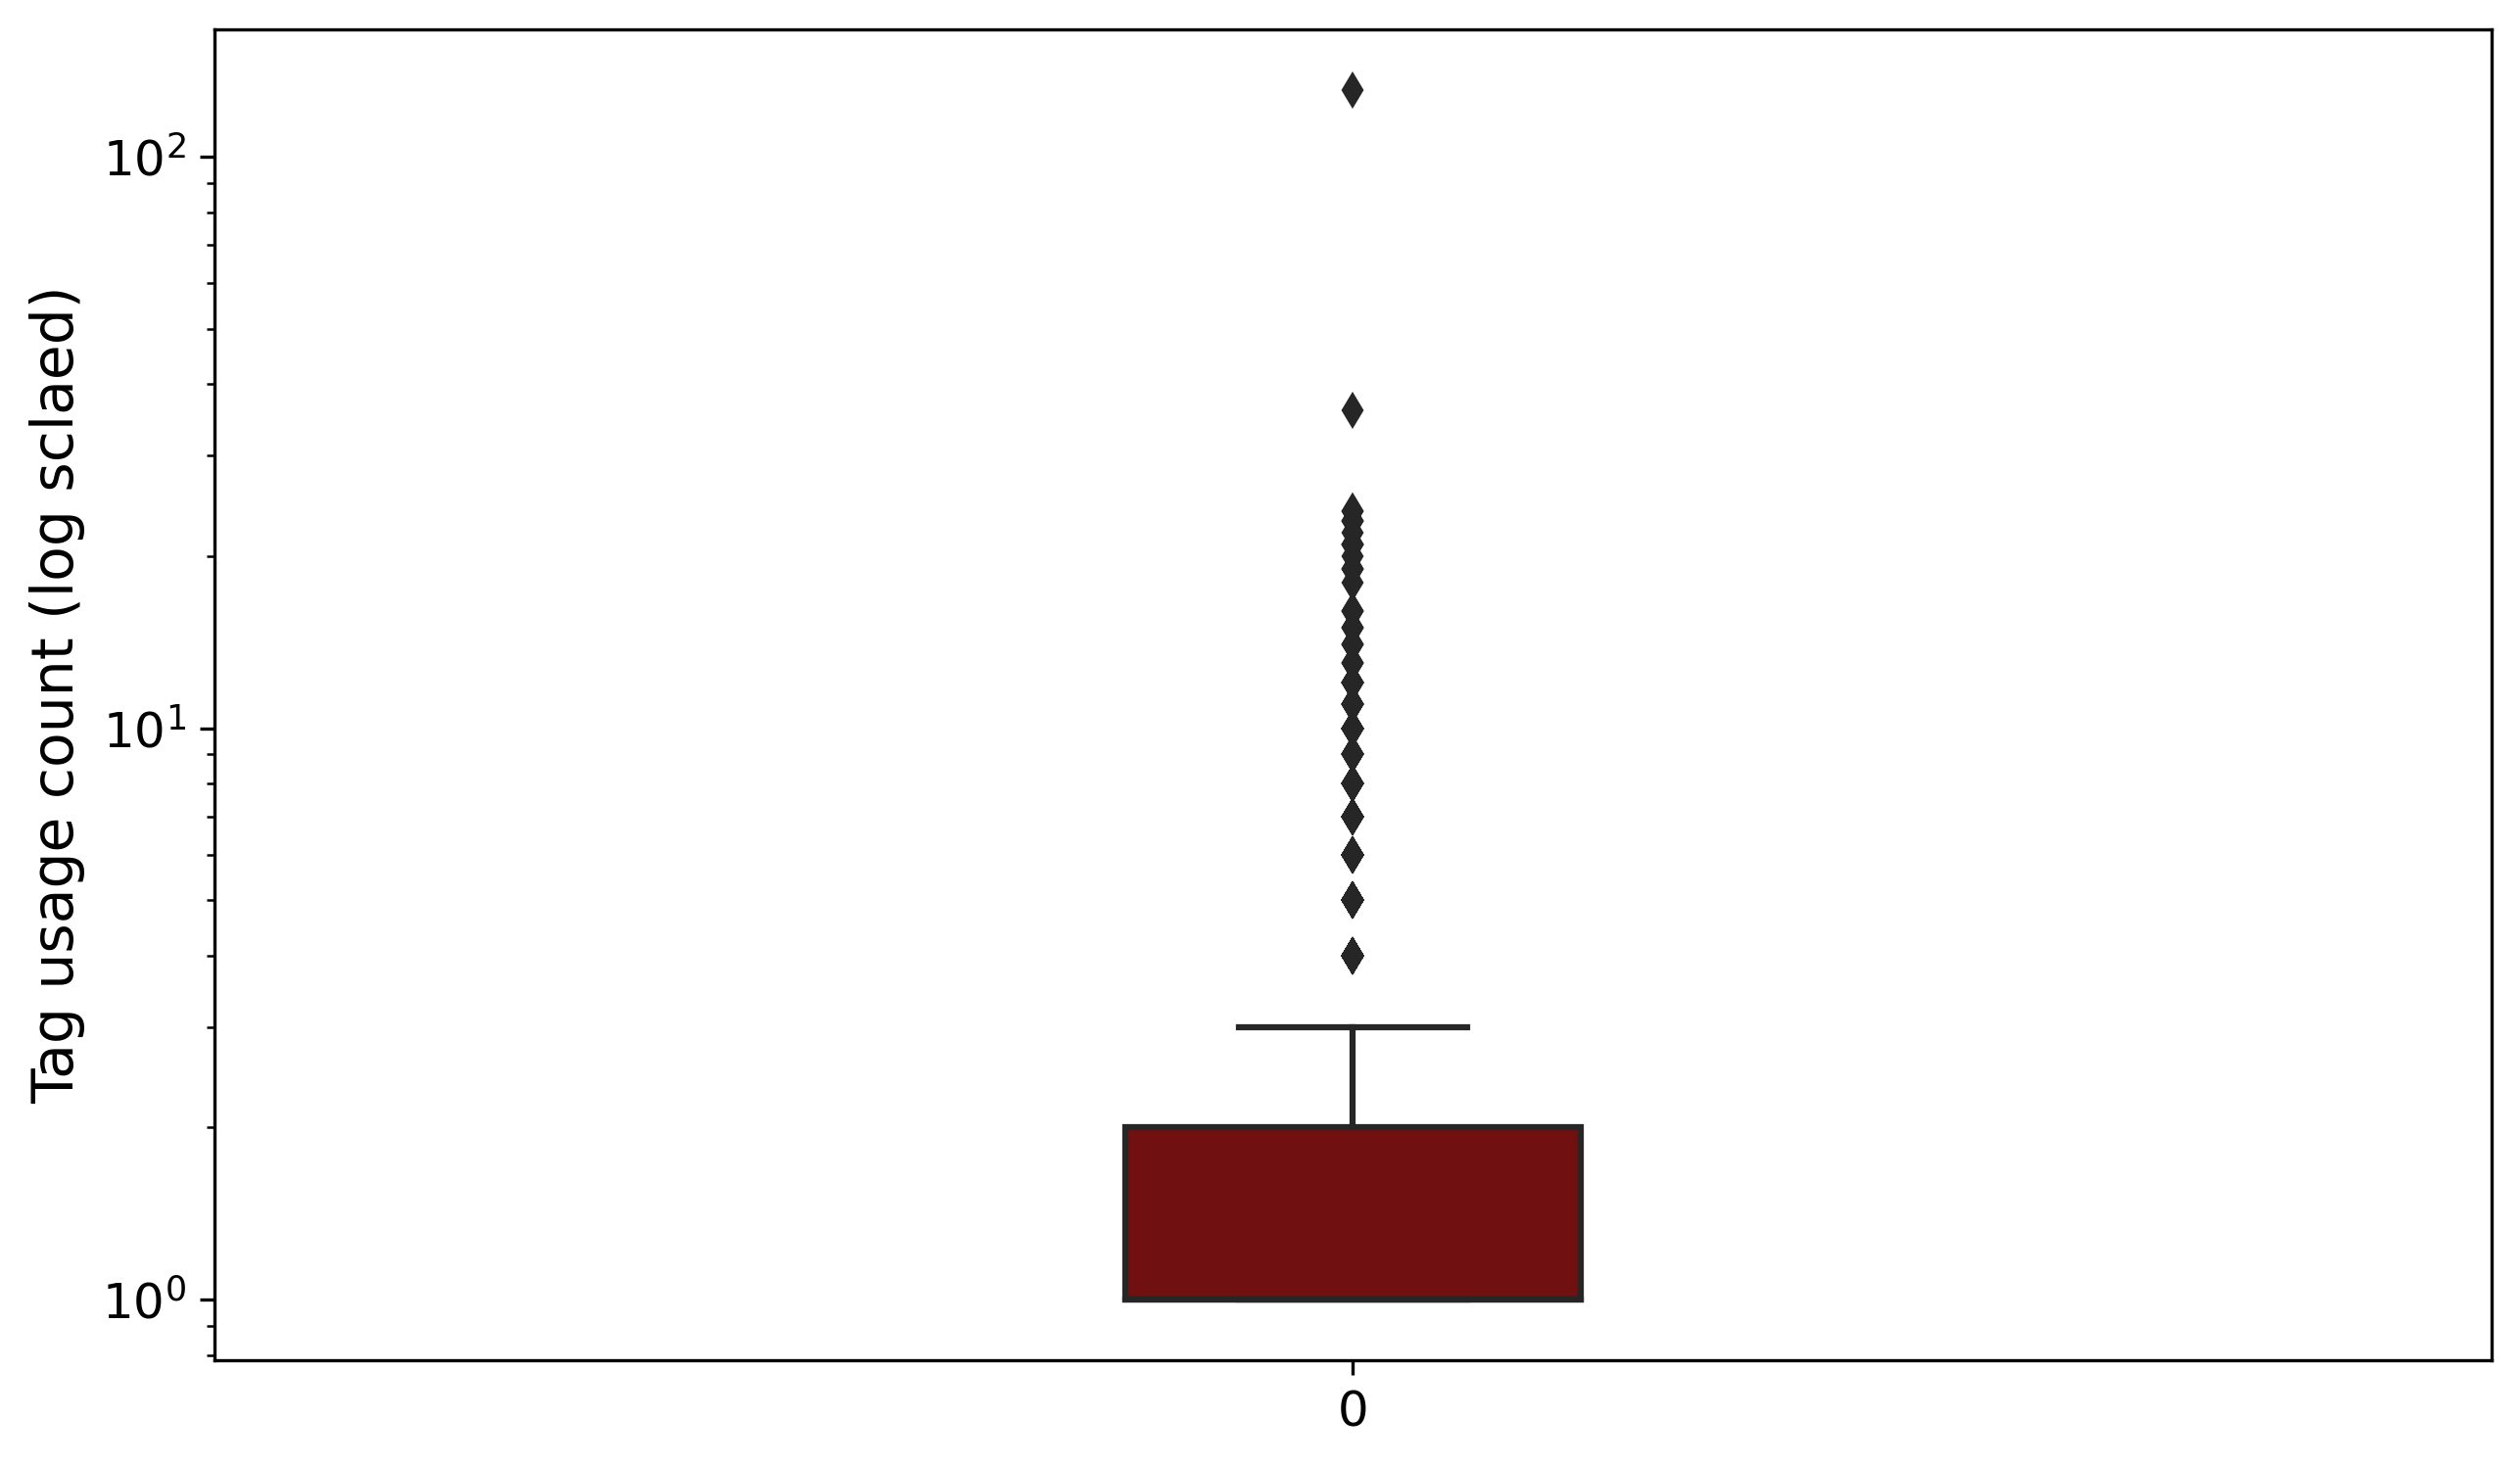

In [180]:
plt.figure(figsize=(10,6), dpi=300)
sns.boxplot(data = tags_df['tag'].value_counts(), width=0.2, color='maroon')
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Tag usage count (log sclaed)", fontsize=14)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../Figures/Movielens/boxplot_tag_usage_count.pdf", format="pdf", bbox_inches="tight")

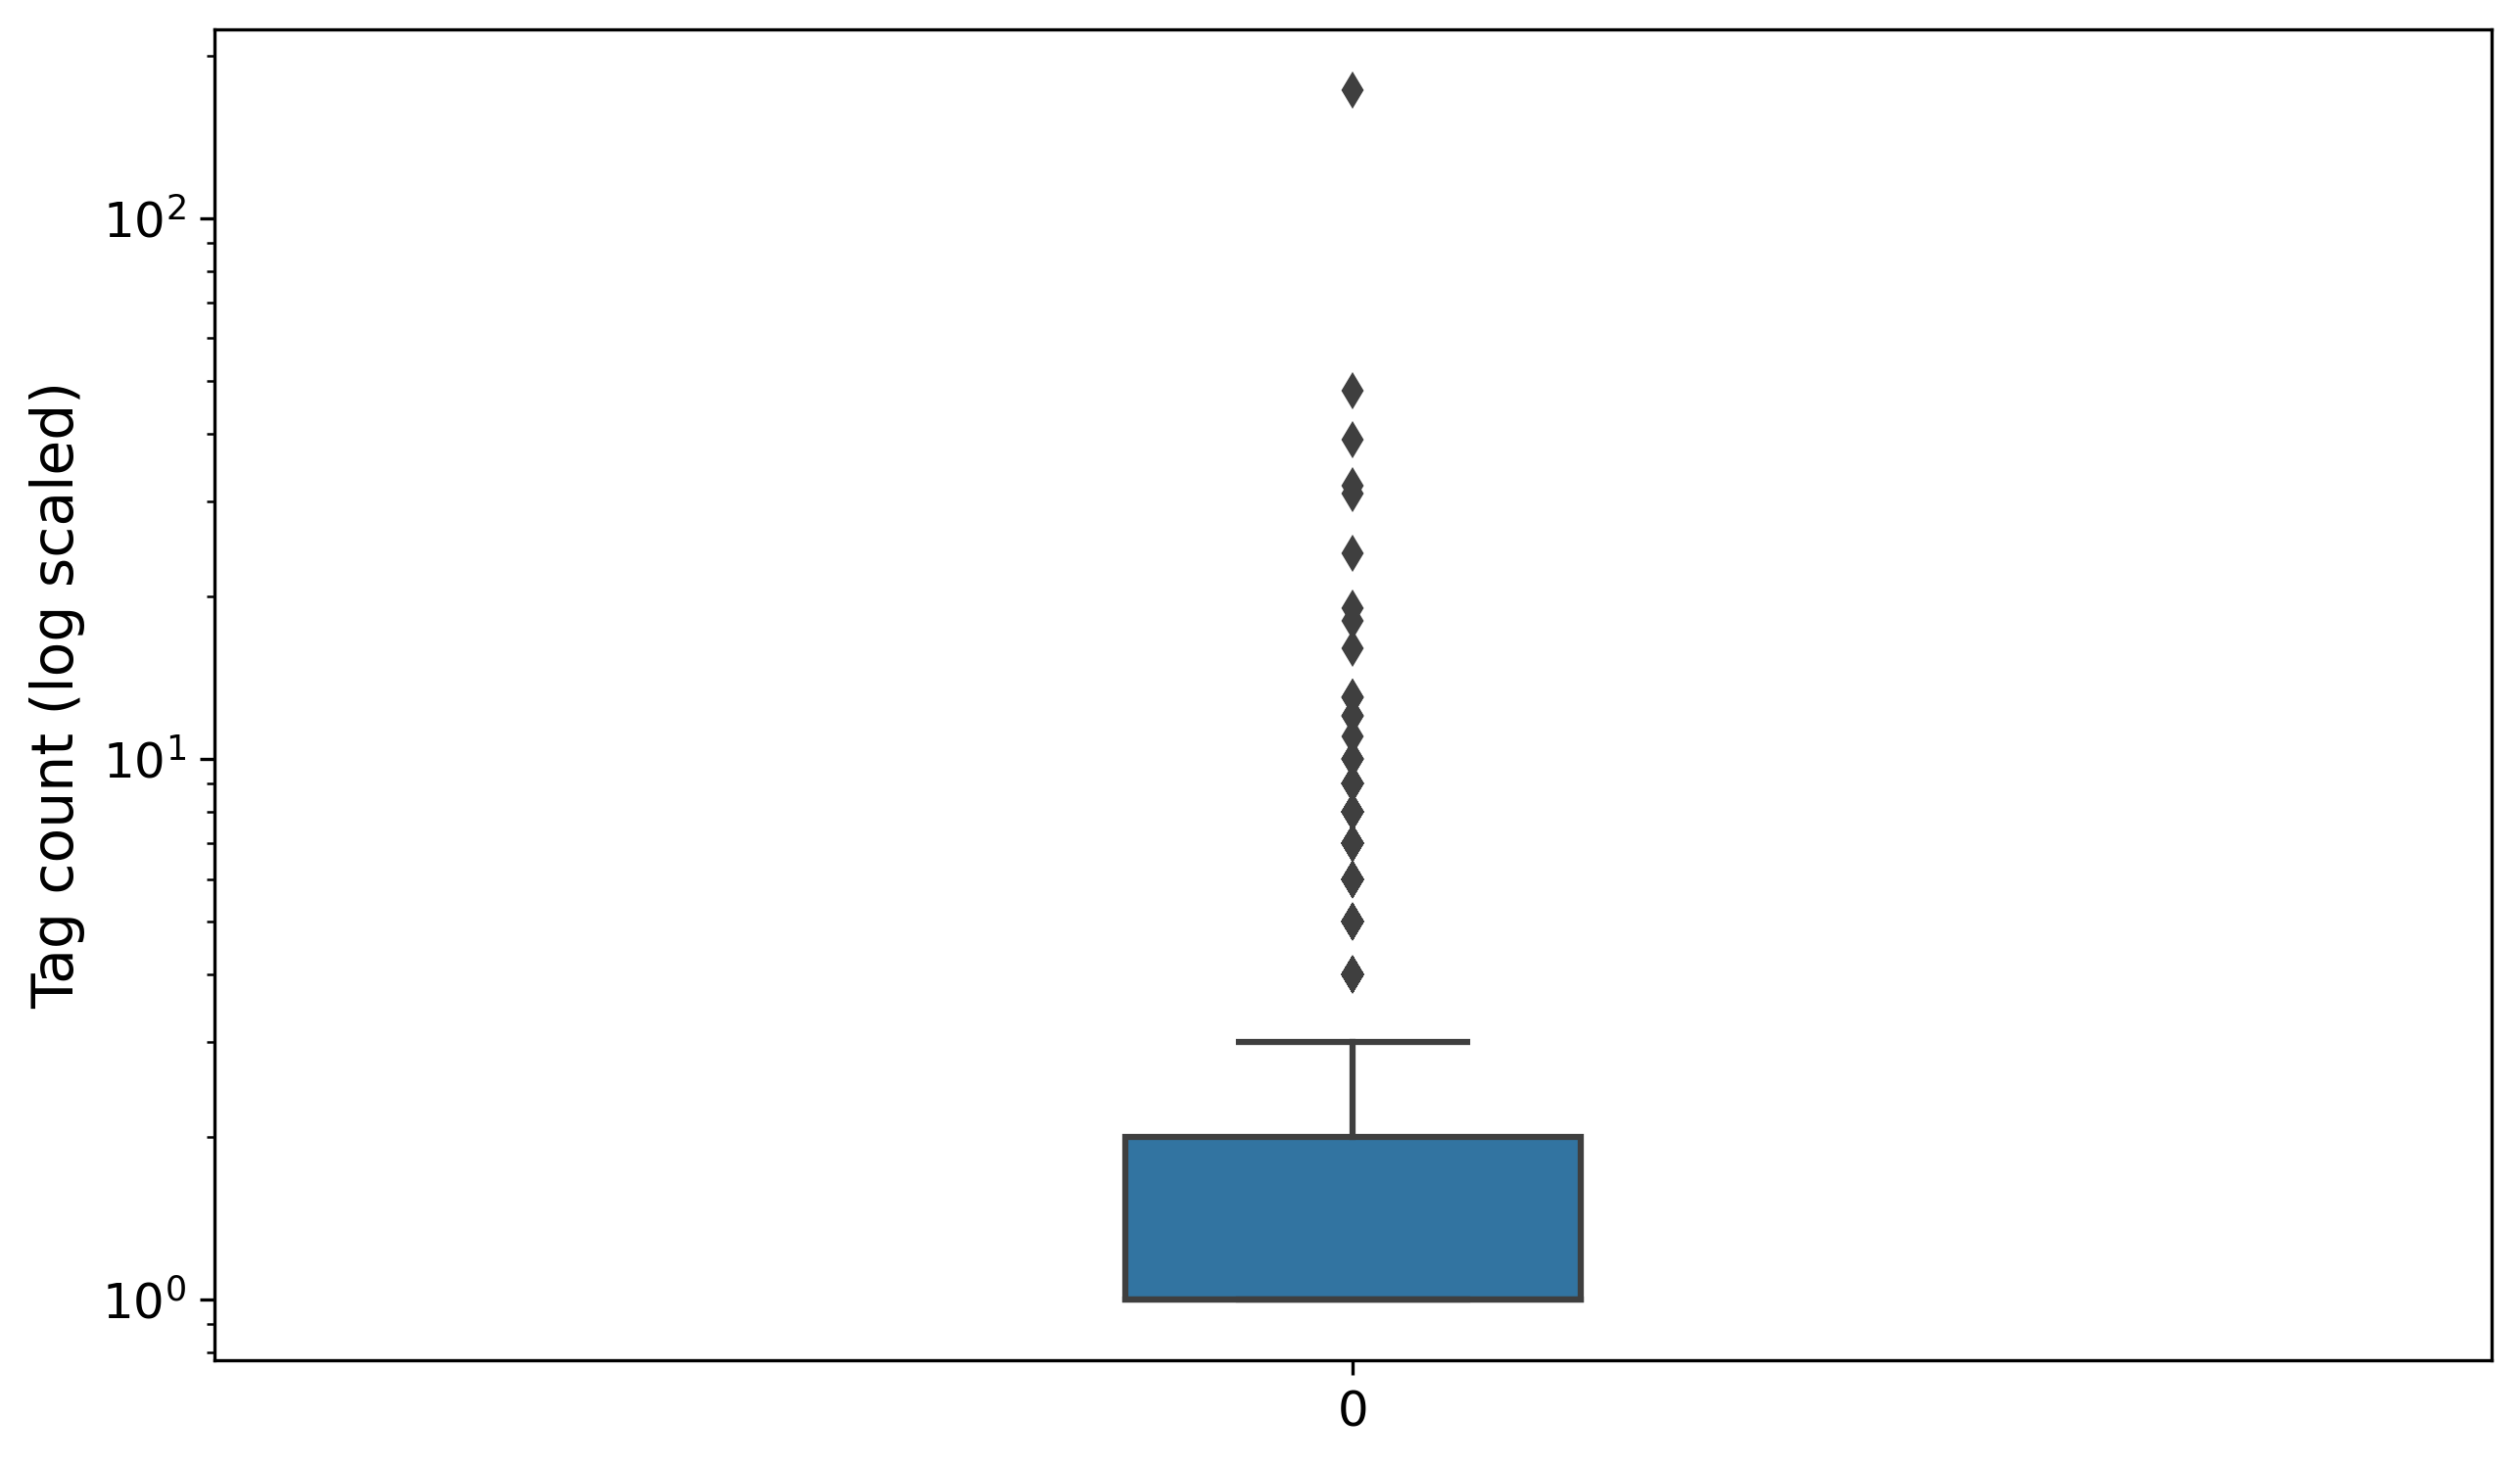

In [181]:
plt.figure(figsize=(10,6), dpi=300)
sns.boxplot(data=tag_counts_per_user, width=0.2)
# plt.xlabel("Genres", fontsize=14)
plt.ylabel("Tag count (log scaled)", fontsize=14)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../Figures/Movielens/boxplot_tag_counts_per_user.pdf", format="pdf", bbox_inches="tight")

In [159]:
# Sample data (replace with your own)
data = {'no of movies rated per user': ratings_df['userId'].value_counts().tolist(),
        'no of times a tag is used': tags_df['tag'].value_counts().tolist(),
        'no of tags to movies by users': tag_counts_per_user,
        'genre count per movie': movies_and_ratings['genre_count_per_movie'].tolist()}
df = pd.DataFrame(data)
plt.figure(dpi=300)
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Create boxplots for each label
sns.boxplot(x="label", y="value", data=df, ax=axes[0, 0])
sns.boxplot(x="label", y="value", data=df, ax=axes[0, 1])
sns.boxplot(x="label", y="value", data=df, ax=axes[1, 0])
sns.boxplot(x="label", y="value", data=df, ax=axes[1, 1])

# Set individual subplot titles
axes[0, 0].set_title("Boxplot 1")
axes[0, 1].set_title("Boxplot 2")
axes[1, 0].set_title("Boxplot 3")
axes[1, 1].set_title("Boxplot 4")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

ValueError: arrays must all be same length

In [184]:
tags_df['movieId'].nunique()

1572

In [188]:
movies_and_ratings['movieId'].nunique() - tags_df['movieId'].nunique()

8152